![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Legal Entity Resolution

## Setup

In [ ]:
from johnsnowlabs import *

import pandas as pd
import json
import os

spark = start_spark()

# Sentence Entity Resolver Models

An NLP use case in financial or legal applications is identifying legal entities' presence in a given text. One of those entities could be `Company Name`. We can carry out NER to extract different chunks of information, but in real financial and legal use cases, the company name is usually not useful as it is mentioned in the text. Sometimes we need the _official_ name of the company (instead of `Amazon`, `Amazon.com INC`, as registered in Edgar). We have pre-trained sentence entity resolver models for these purposes shown below with the examples.

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

### Helper Function
We will use following Generic Function For Getting the Codes and Relation Pairs

In [2]:
# returns LP resolution results

pd.set_option('display.max_colwidth', 0)

def get_codes (lp, text, vocab='company_name', hcc=False):
    
    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []
    all_k_aux_labels=[]

    for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][vocab]):
            
        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        codes.append(code.result) 
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))
        all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))
        if hcc:
            try:
                all_k_aux_labels.append(code.metadata['all_k_aux_labels'].split(':::'))
            except:
                all_k_aux_labels.append([])
        else:
            all_k_aux_labels.append([])

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes, 
                       'resolutions':resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_cosines})
    
    return df

## Sentence Entity Resolver (EDGAR)
[Edgar's Public Database](https://www.sec.gov/edgar/searchedgar/companysearch)

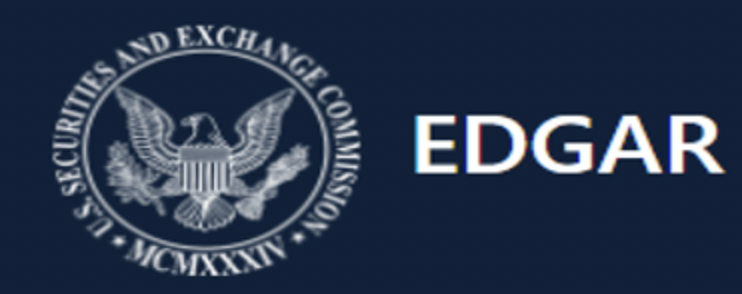



- EDGAR, the Electronic Data Gathering, Analysis, and Retrieval system, is the primary system for companies and others submitting documents under the Securities Act of 1933, the Securities Exchange Act of 1934, the Trust Indenture Act of 1939, and the Investment Company Act of 1940. 

- Access to EDGAR’s public database is free—allowing you to research, for example, a public company’s financial information and operations by reviewing the filings the company makes with the SEC.(U.S. Securities and Exchange Commission)

Here we will normalize company names and find IRS code of each company with the Edgar's Database

### Company Name Normalization

`Company Name Normalization` is the process of obtaining the name of the company used by data providers, usually the "official" name of the company.

Sometimes, some data providers may have different versions of the name with different punctuation. For example, for Meta:
- Meta Platforms, Inc.
- Meta Platforms Inc.
- Meta Platforms, Inc
- etc

So, it's mandatory we do `Company Normalization` taking into account the database / datasource provider we want to extract data from. The data providers we have are:
- SEC Edgar
- Crunchbase until 2015
- Wikidata (in progress)

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

embeddings = nlp.UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
      .setInputCols("ner_chunk") \
      .setOutputCol("sentence_embeddings")
    
resolver = legal.SentenceEntityResolverModel.pretrained("legel_edgar_company_name", "en", "legal/models") \
      .setInputCols(["sentence_embeddings"]) \
      .setOutputCol("normalized_name")\
      .setDistanceFunction("EUCLIDEAN")

pipelineModel = nlp.PipelineModel(stages = [
          documentAssembler,
          embeddings,
          resolver])

lp = nlp.LightPipeline(pipelineModel)

In [5]:
text = 'Pre Paid Legal Services'

%time get_codes (lp, text, vocab='normalized_name')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 5.29 ms, sys: 4.53 ms, total: 9.82 ms
Wall time: 1.52 s


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Pre Paid Legal Services,0,22,PRE PAID LEGAL SERVICES INC,"[PRE PAID LEGAL SERVICES INC, AMERICAN PREPAID LEGAL SERVICES, VIRTU FINANCIAL BD LLC, Virtu Financial BD LLC, HJ Umbaugh Associates Certified Public Accountants LLP, Commerce Nursing Homes LLC, IRUNURUN LLC, Camas Associates LLC, Court Document Services Inc, EZC Medical LLC, Virtu Financial LLC, CST Services LLC, Tontine Associates LLC, JENNISON ASSOCIATES LLC, VTL Associates LLC, Emancipation Management LLC, Hotel Internet Services LLC, Frasca Associates LLC, BCIP T Associates III LLC, MEDIACOM LLC, BBR PARTNERS LLC, Watauga Associates LLC, JCRA FINANCIAL LLC, LifePoint Billing Services LLC]","[PRE PAID LEGAL SERVICES INC, AMERICAN PREPAID LEGAL SERVICES, VIRTU FINANCIAL BD LLC, Virtu Financial BD LLC, HJ Umbaugh Associates Certified Public Accountants LLP, Commerce Nursing Homes LLC, IRUNURUN LLC, Camas Associates LLC, Court Document Services Inc, EZC Medical LLC, Virtu Financial LLC, CST Services LLC, Tontine Associates LLC, JENNISON ASSOCIATES LLC, VTL Associates LLC, Emancipation Management LLC, Hotel Internet Services LLC, Frasca Associates LLC, BCIP T Associates III LLC, MEDIACOM LLC, BBR PARTNERS LLC, Watauga Associates LLC, JCRA FINANCIAL LLC, LifePoint Billing Services LLC]",[],"[0.0553, 0.2114, 0.2679, 0.2679, 0.2806, 0.2823, 0.2881, 0.2881, 0.2883, 0.2892, 0.2895, 0.2895, 0.2897, 0.2919, 0.2932, 0.2932, 0.2949, 0.2952, 0.2963, 0.2966, 0.2980, 0.2980, 0.2981, 0.2986]"


In [6]:
text = 'Legal Research Center inc'

%time get_codes (lp, text, vocab='normalized_name')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 6.62 ms, sys: 1.04 ms, total: 7.66 ms
Wall time: 1.29 s


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Legal Research Center inc,0,24,LEGAL RESEARCH CENTER INC,"[LEGAL RESEARCH CENTER INC, Vector Research LLC, MATRIXX INITIATIVES INC, SYMIC BIOMEDICAL INC, Alliqua BioMedical Inc, EXPERIENTIAL AGENCY INC, PREMIER BIOMEDICAL INC]","[LEGAL RESEARCH CENTER INC, Vector Research LLC, MATRIXX INITIATIVES INC, SYMIC BIOMEDICAL INC, Alliqua BioMedical Inc, EXPERIENTIAL AGENCY INC, PREMIER BIOMEDICAL INC]",[],"[0.0000, 0.2192, 0.2386, 0.2387, 0.2393, 0.2424, 0.2440]"


In [7]:
text = 'Cyber Law Reporter'

%time get_codes (lp, text, vocab='normalized_name')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 7.68 ms, sys: 1.09 ms, total: 8.78 ms
Wall time: 1.3 s


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Cyber Law Reporter,0,17,CYBER LAW REPORTER INC,"[CYBER LAW REPORTER INC, Cyber Informatix Inc, CETERA ADVISOR NETWORKS LLC, Cetera Advisor Networks LLC, COUNSEL COMMUNICATIONS LLC, AirTouch Communications Inc, GEO Corrections Detention LLC]","[CYBER LAW REPORTER INC, Cyber Informatix Inc, CETERA ADVISOR NETWORKS LLC, Cetera Advisor Networks LLC, COUNSEL COMMUNICATIONS LLC, AirTouch Communications Inc, GEO Corrections Detention LLC]",[],"[0.0548, 0.2975, 0.3243, 0.3243, 0.3343, 0.3365, 0.3397]"


### Find Company IRS Number

An employer identification number (EIN) is a nine-digit number assigned by the `IRS`. It's used to identify the tax accounts of employers and certain others who have no employees. The IRS uses the number to identify taxpayers who are required to file various business tax returns. EINs are used by employers, sole proprietors, corporations, partnerships, non-profit associations, trusts, estates of decedents, government agencies, certain individuals, and other business entities.



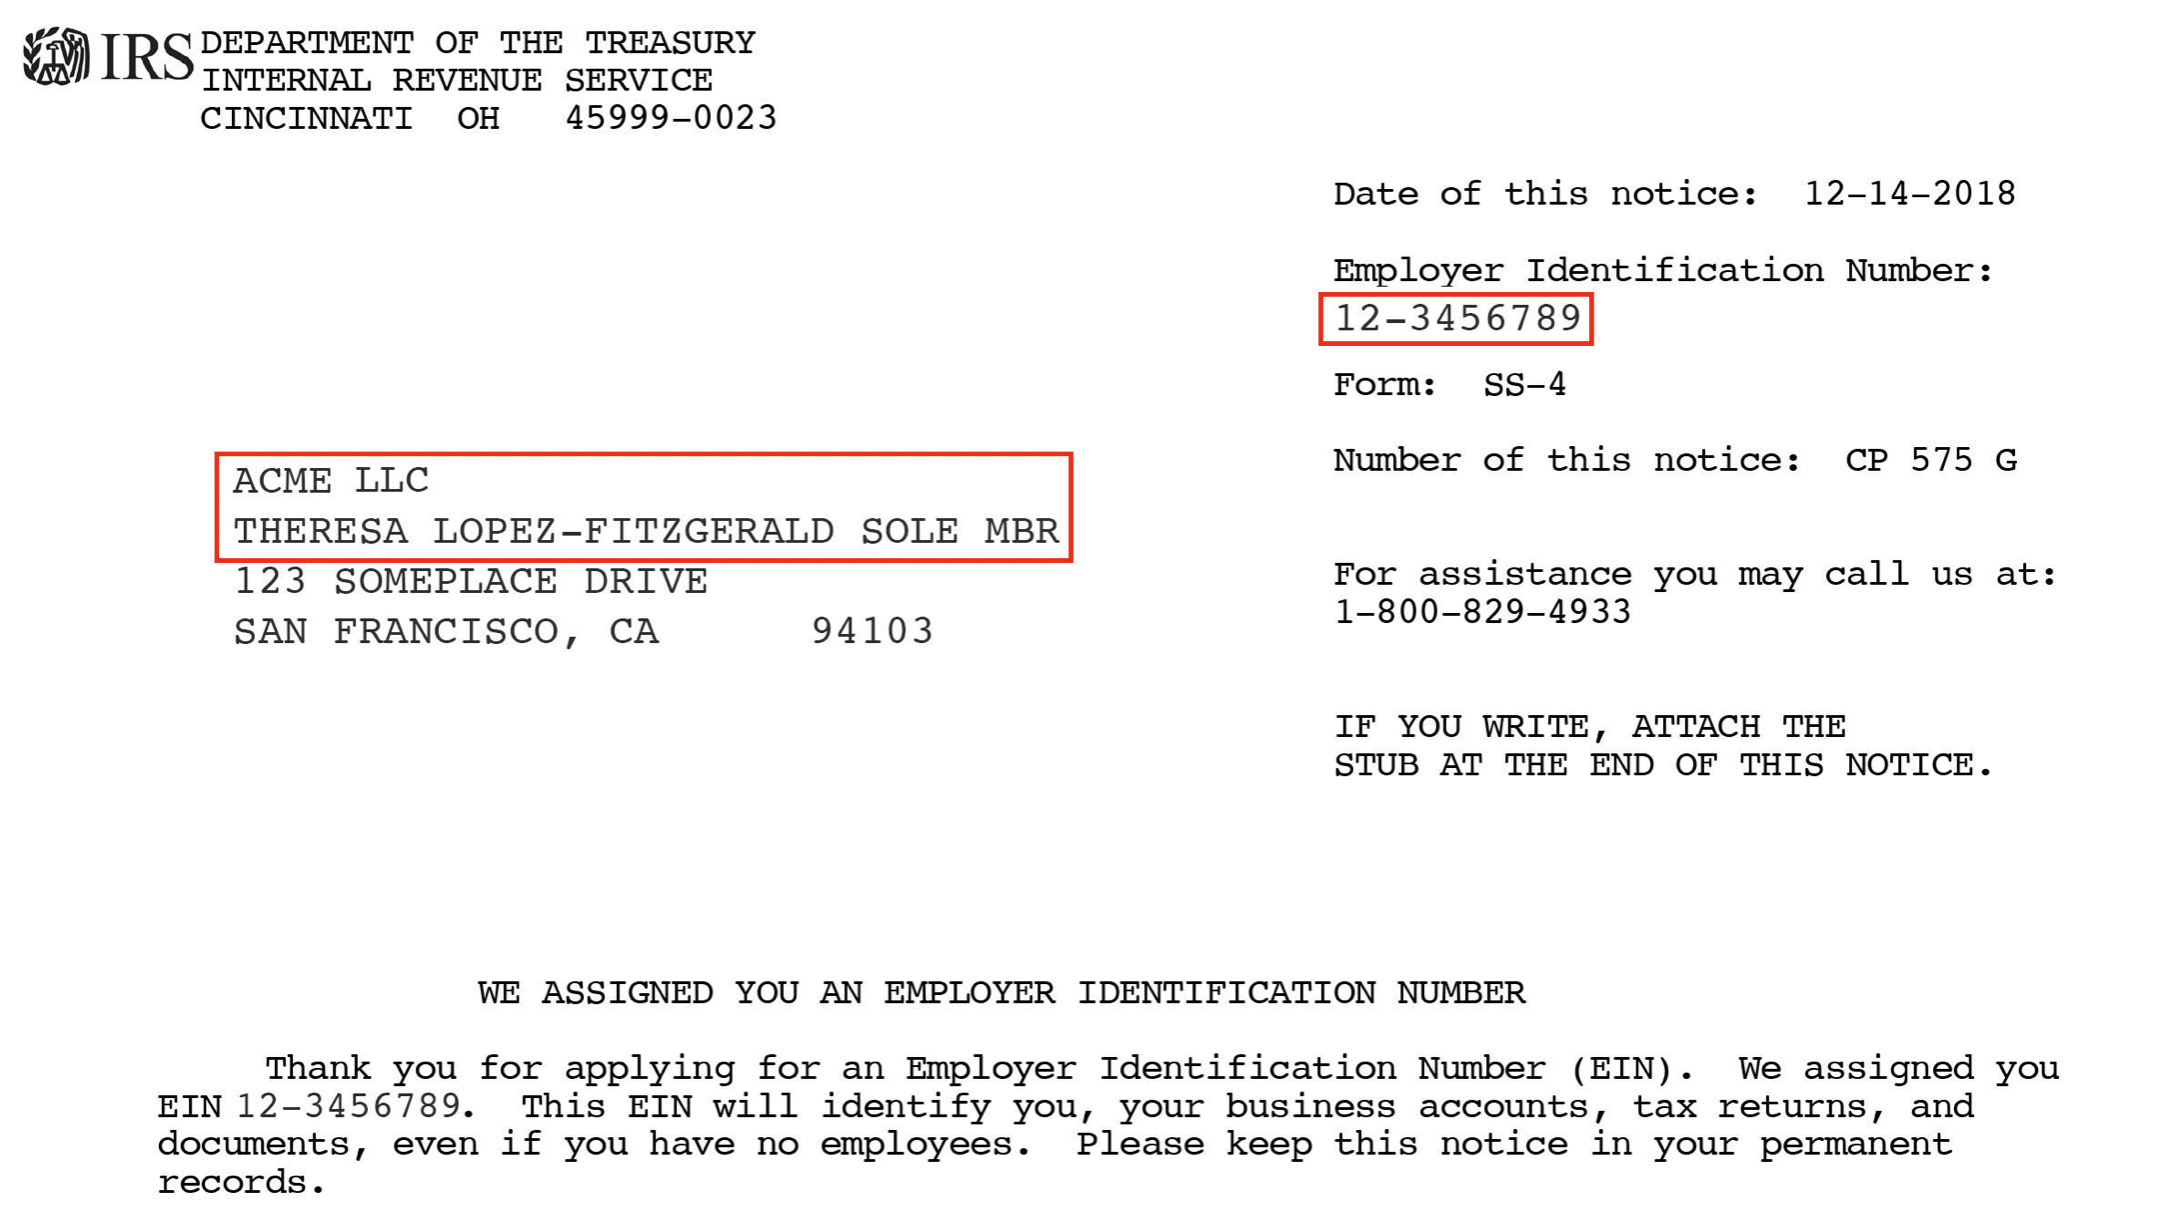

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

embeddings = nlp.UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
      .setInputCols("ner_chunk") \
      .setOutputCol("sentence_embeddings")
    
resolver = legal.SentenceEntityResolverModel.pretrained("legel_edgar_irs", "en", "legal/models") \
      .setInputCols(["sentence_embeddings"]) \
      .setOutputCol("irs_code")\
      .setDistanceFunction("EUCLIDEAN")

pipelineModel = nlp.PipelineModel(
      stages = [
          documentAssembler,
          embeddings,
          resolver])

lp = nlp.LightPipeline(pipelineModel)

In [9]:
text = 'LEGAL GENERAL INVESTMENT MANAGEMENT AMERICA INC'

%time get_codes (lp, text, vocab='irs_code')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 6.29 ms, sys: 889 µs, total: 7.18 ms
Wall time: 1.27 s


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,LEGAL GENERAL INVESTMENT MANAGEMENT AMERICA INC,0,46,208058531,"[208058531, 0, 440640487, 133008848]","[Legal General Investment Management America Inc, Legal General Investment Management America, AMERICAN CENTURY INVESTMENT MANAGEMENT INC, AMERICAN CAPITAL MANAGEMENT INC]",[],"[0.0000, 0.0403, 0.1420, 0.1569]"


In [10]:
text = 'Justice Delawere Holdco inc'

%time get_codes (lp, text, vocab='irs_code')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 6.29 ms, sys: 888 µs, total: 7.18 ms
Wall time: 1.22 s


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Justice Delawere Holdco inc,0,26,455011014,"[455011014, 0, 954695021, 231726661, 261327790, 352567439, 521951797]","[Justice Delaware Holdco Inc, ChowNow Inc, PeopleSupport Inc, JUDGE GROUP INC, ABVIVA INC, MOVEIX INC, PATAPSCO BANCORP INC]",[],"[0.1576, 0.2576, 0.2630, 0.2637, 0.2648, 0.2690, 0.2738]"


In [11]:
text = 'Legal Research Center inc'

%time get_codes (lp, text, vocab='irs_code')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 6.38 ms, sys: 916 µs, total: 7.29 ms
Wall time: 1.29 s


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Legal Research Center inc,0,24,411680384,"[411680384, 0, 870482806, 582349413, 880471263]","[LEGAL RESEARCH CENTER INC, Vector Research LLC, MATRIXX INITIATIVES INC, Alliqua BioMedical Inc, EXPERIENTIAL AGENCY INC]",[],"[0.0000, 0.2192, 0.2386, 0.2393, 0.2424]"


## Sentence Entity Resolver (CRUNCHBASE)
[Crunchbase Homepage](https://www.crunchbase.com/)

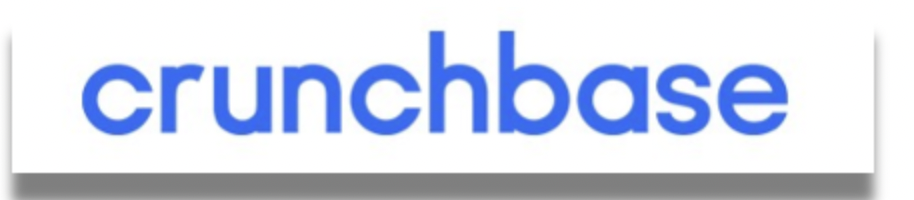


- Crunchbase is a platform for gaining awareness about business information about private and public companies. Originally built to track startups, the Crunchbase website contains information on public and private companies on a global scale.

Here we will normalize company names with the Crunchbase Database

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

embeddings = nlp.UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
      .setInputCols("ner_chunk") \
      .setOutputCol("sentence_embeddings")
    
resolver = legal.SentenceEntityResolverModel.pretrained("legel_crunchbase_companynames", "en", "legal/models") \
      .setInputCols(["sentence_embeddings"]) \
      .setOutputCol("name")\
      .setDistanceFunction("EUCLIDEAN")

pipelineModel = nlp.PipelineModel(stages = [
          documentAssembler,
          embeddings,
          resolver])

lp = nlp.LightPipeline(pipelineModel)

In [14]:
text = 'Legalcrunch'

%time get_codes (lp, text, vocab='name')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 6.21 ms, sys: 829 µs, total: 7.04 ms
Wall time: 605 ms


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Legalcrunch,0,10,"LegalCrunch, Inc.","[LegalCrunch, Inc., Pitzi, Adisn, XChanger Companies, Terviu, Brazzlebox, AnySource Media, ikaSystems, Teikhos Tech, ProPlan]","[LegalCrunch, Inc., Pitzi, Adisn, XChanger Companies, Terviu, Brazzlebox, AnySource Media, ikaSystems, Teikhos Tech, ProPlan]",[],"[0.0000, 0.0373, 0.0391, 0.0411, 0.0435, 0.0441, 0.0452, 0.0454, 0.0455, 0.0460]"


In [15]:
text = 'Shwrm'

%time get_codes (lp, text, vocab='name')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 7.28 ms, sys: 0 ns, total: 7.28 ms
Wall time: 615 ms


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Shwrm,0,4,Shwrüm,"[Shwrüm, Xervmon Inc, ADVANCED CREDIT TECHNOLOGIES, Quickcomm Software Solutions, citysocializer, SurgiQuest, ShoutNow, Reset Therapeutics, MoneyReef, TopiVert, Brevity, Phoenix Health and Safety, Learnpedia Edutech Solutions, Stumpedia]","[Shwrüm, Xervmon Inc, ADVANCED CREDIT TECHNOLOGIES, Quickcomm Software Solutions, citysocializer, SurgiQuest, ShoutNow, Reset Therapeutics, MoneyReef, TopiVert, Brevity, Phoenix Health and Safety, Learnpedia Edutech Solutions, Stumpedia]",[],"[0.0000, 0.0436, 0.0448, 0.0471, 0.0488, 0.0488, 0.0491, 0.0497, 0.0497, 0.0500, 0.0500, 0.0504, 0.0507, 0.0507]"


In [16]:
text = 'Waywire'

%time get_codes (lp, text, vocab='name')

1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
1g6ax7jxec82paqzk7ivz9fx7
codes retrieved: ArrayBuffer(1g6ax7jxec82paqzk7ivz9fx7), product code(from property): 1g6ax7jxec82paqzk7ivz9fx7
CPU times: user 5.94 ms, sys: 1.66 ms, total: 7.61 ms
Wall time: 598 ms


,chunks,begin,end,code,all_codes,resolutions,all_k_aux_labels,all_distances
0,Waywire,0,6,#waywire,"[#waywire, Limonetik, Totally Interactive Weather, ThoughtFocus, 2345.com, WebNotes, Synovex, relocality, Grab Media]","[#waywire, Limonetik, Totally Interactive Weather, ThoughtFocus, 2345.com, WebNotes, Synovex, relocality, Grab Media]",[],"[0.0000, 0.0431, 0.0434, 0.0441, 0.0443, 0.0445, 0.0452, 0.0458, 0.0459]"


22/12/12 18:40:09 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/spark-4ead7c4f-e521-45b2-8d7e-3c142baed288/userFiles-2dcfd486-d8dd-4bcb-8f11-06e077d6df80. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/spark-4ead7c4f-e521-45b2-8d7e-3c142baed288/userFiles-2dcfd486-d8dd-4bcb-8f11-06e077d6df80
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:171)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:110)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:91)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1141)
	at org.apache.spark.SparkEnv.stop(SparkEnv.scala:105)
	at org.apache.spark.SparkContext.$anonfun$stop$23(SparkContext.scala:2108)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1419)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2108)
	at org.apache.spark.SparkContext.$anonfun$new$3